<a href="https://colab.research.google.com/github/nandir2512/Bert/blob/main/Movie_Review_Huggingface_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We use the `transformers` package from `HuggingFace` for pre-trained `transformers-based` language models

In [1]:
!pip install transformers
import nltk
nltk.download('movie_reviews')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.0 MB/s eta 0:00:00


[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Package Import

In [2]:
import pandas as pd, numpy as np
import sklearn
import unicodedata
import random, re, nltk
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification


In [3]:
print(tf.__version__)
print(transformers.__version__)

2.12.0
4.34.0


In [4]:
tf.reshape(tf.constant(1), (-1,1))

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>

## Data Loading

In [5]:
documents = [(' '.join(movie_reviews.words(fileid)), category)
            for category in movie_reviews.categories()
            for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)

## Train-Test Split

In [6]:
train_set, test_set = train_test_split(documents, train_size=0.25, test_size=0.05, random_state=42)

print(len(train_set), len(test_set))

500 100


## Define X and y

In [7]:
X_train_text = [text for (text, label) in train_set]
y_train = [1 if label == 'pos' else 0 for text, label in train_set]

X_test_text = [text for (text, label) in test_set]
y_test = [1 if label == 'pos' else 0 for text, label in test_set]

## HuggingFace transformers
In transformers, we can access many different versions of pre-trained BERT models:

  * BERT-Base, Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters
  * BERT-Large, Uncased: 24-layer, 1024-hidden, 16-heads, 340M parameters
  * BERT-Base, Cased: 12-layer, 768-hidden, 12-heads , 110M parameters
  * BERT-Large, Cased: 24-layer, 1024-hidden, 16-heads, 340M parameters

# Tokenizers
* Each pre-trained model follows a specific mechanism of tokenization.
* Therefore, we need to use the model-specific tokenizer for text vectorization.
* Specifically, BERT uses the WordPiece tokenization.

In [8]:
num_classes =2
bert_tokenizer = BertTokenizer.from_pretrained ("bert-base-uncased", do_lower_case=True)

## Intuition of BERT Tokenizer
`BertTokenizer.tokenize()` tokenizes sequences into word-pieces.

In [9]:
sent = "Don't like it!"
tokens = bert_tokenizer.tokenize(sent)
print(tokens)

['don', "'", 't', 'like', 'it', '!']


In [10]:
bert_tokenizer.encode_plus(sent)

{'input_ids': [101, 2123, 1005, 1056, 2066, 2009, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

## BertTokenizer.encode_plus()
* We use `BertTokenizer.encode_plus()` to convert sequences into input formats for later BERT-based classifier.
* `BertTokenizer.encode_plus()` returns a dictionary of three objects:
  * `input_ids`: These correspond to the integers/sequences of the tokens in the input (i.e., the text_to_sequences() in keras).
  * `type_token_ids`: These ids indicate the sentence number that tokens belong to. (BERT can take up to two sequences at a time).
  * `attention_mask`: Similar to keras Mask layer, this mask indicates with tokens are actual tokens and which are padding tokens so that the attention calculation would ignore the latter.

In [11]:
tokenized_sequence = bert_tokenizer.encode_plus(sent,
                                                add_special_tokens=True,
                                                max_length=10,
                                                padding='max_length',
                                                truncation=True,
                                                return_attention_mask=True)

tokenized_sequence

{'input_ids': [101, 2123, 1005, 1056, 2066, 2009, 999, 102, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}

BertTokenizer, when tokenizing the sequences, would add special tokens. Important special tokens include:

* [SEP] and [CLS] are special tokens added by the BertTokenizer.
* [SEP] is needed when the task required two sequences at a time (e.g., in BERT training).
* [CLS], added at the beginning of the input, stand for classifier token. The embedding of this token can be seen as the summary of the inputs, which is ready for downstream classification problems. That is, this pooled output [CLS] can the input of the additional layers on top of the BERT model (i.e., [CLS] can be viewed as the document embeddings).
* [CLS] = 101 & [SEP] = 102 token value

In [12]:
bert_tokenizer.decode(tokenized_sequence['input_ids'],
                      clean_up_tokenization_spaces=False)

"[CLS] don ' t like it ! [SEP] [PAD] [PAD]"

# From Text to BERT Input
* When tokenizing, we can determine the `max_length` of each text.
* Also, we need to specify `padding` and `truncation` to make sure that the `BertTokenizer` automatically pad/truncate the sequences to uniform lengths.

In [13]:
y_train = np.array(y_train)
y_test = np.array(y_test)

Important Arguments of BertTokenizer.encode_plus():

* `text:` The sequence or batch of sequences to be encoded. Each sequence can be a string or a list of strings (pretokenized string).
* `add_special_tokens:` Whether or not to encode the sequences with the special tokens relative to their model.
* `max_length:` Controls the maximum length to use by one of the truncation/padding parameters. (max_length≤512)
* `padding:` Whether or not to pad the sequences to the maximum length.
* `return_attention_mask`

In [14]:
def convert_example_to_feature(review):
  return bert_tokenizer.encode_plus(review,
                                    add_special_token = True,  #add[CLS],[SEP]
                                    max_length = 256,   #max length of the text that can go to Bert
                                    padding= 'max_length',
                                    truncation= True,
                                    return_attention_mast =True,  #add attention mask to not focus on pad tokens

                                    )

Then we prepare inputs for later Bert-based classifier (i.e.TFBertForSequenceClassification).

In [15]:
# map to the expected input to TFBertForSequenceClassification

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  #prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list,
                                              token_type_ids_list, label_list)).map(map_example_to_dict)



In [16]:
# hyper-parameters
batch_size = 8


In [17]:
#train dataset

ds_train = zip(X_train_text, y_train)
ds_test = zip(X_test_text, y_test)
ds_train_encoded = encode_examples(ds_train).shuffle(len(X_train_text)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast': True} not recognized.
Keyword arguments {'add_special_token': True, 'return_attention_mast':

In [18]:
ds_train_encoded

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

## Model Setup
transformers provides a BERT-based document classifier for fine-tuning, i.e., `TFBertForSequenceClassification`

In [19]:
## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes)

bert_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [20]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
#multiple epochs might be better as long as we will not overfit the model
number_of_epochs=2

#choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
#we do not have one-hot vectors, we can sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics= metric)



The BERT paper suggests a few heuristics for fine-tuning:

* Batch Size: 16 or 32
* Epochs: 2 to 4
* Learning Rates for Adam: 5e-5, 3e-5,, or 2e-5.

## Model Training

* The BERT Classifier requires two inputs: the input_ids and the attention_mask (from BertTokenizer.encode_plus().
* The output should be the one-hot encoded labels.

In [21]:
history = bert_model.fit(ds_train_encoded,
                         batch_size= batch_size,
                         epochs= number_of_epochs,
                         validation_data=ds_test_encoded)

Epoch 1/2
63/63 [==============================] - 2044s 32s/step - loss: 0.6835 - accuracy: 0.5760 - val_loss: 0.6330 - val_accuracy: 0.7200
Epoch 2/2
63/63 [==============================] - 1974s 31s/step - loss: 0.5399 - accuracy: 0.7820 - val_loss: 0.4861 - val_accuracy: 0.7400


In [22]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

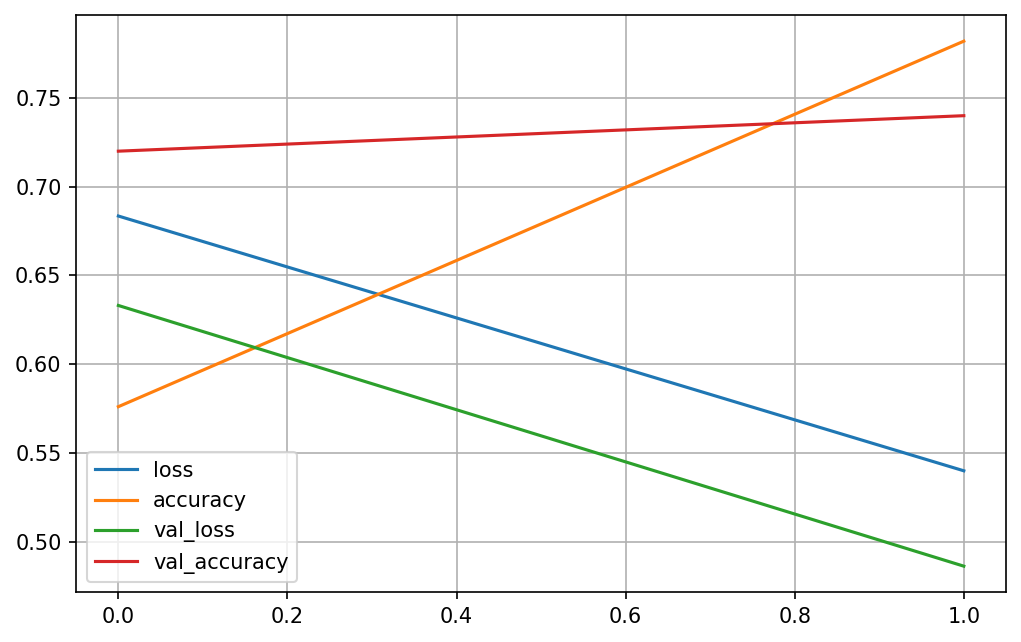

In [23]:
plot2(history)

## Model Evaluation

In [24]:
bert_model.evaluate(ds_test_encoded, batch_size=batch_size)

13/13 [==============================] - 110s 8s/step - loss: 0.4861 - accuracy: 0.7400


[0.48611709475517273, 0.7400000095367432]

In [25]:
y_test_pred = bert_model.predict(ds_test_encoded, batch_size=batch_size)

13/13 [==============================] - 114s 8s/step


In [26]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)

In [27]:
print(y_test_pred_class[:10])
print(y_test[:10])

[1 0 1 0 1 0 0 0 1 1]
[1 0 1 1 1 0 0 0 1 1]


### Important Note:
* We can imporve the Model accuracy by changing
    * Batch Size: 16 or 32
    * Epochs: 2 to 4
    * Learning Rates for Adam: 5e-5, 3e-5,, or 2e-5.